In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'], # like - nejednoznacne 
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confuse', 'stuck', 'puzzle'],
    'Expectation' : ['expect', 'hope', 'anticipate', 'assume', 'suppose'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'preferable', 'favor', 'suggest'] # 'like better', 'go for'
}

In [5]:
with open("speech/martin.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

['Spend one to spend one or two minutes familiarizing yourself with the website.', "OK. OK, I'm scrolling around the website and looking.", 'To what I can find.', 'There is information about vacation testing called plus some useful applications.', "Uh, yeah, I can switch the language and we'll some stats.", 'I saw some advanced statistics.', 'Also, there is code Automat which is currently disabled.', 'You can register for the first or.', '3rd dose of the vacation.', 'And also register for tests VCR and IG.', "OK, let's let's continue to the next task.", 'Describe your initial impressions with the web.', 'With.', "First of all, I think it's quite a quite a long way to down, like.", "I mean it's there's so much information that I can keep scrolling and scrolling feels forever.", 'Uh, I would prefer if there were.', "Maybe some kind of tabs where I can on the top where I can choose if I'm interested in tests or what vaccination or some other applications and.", 'Nation.', 'Find the task n

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['Spend one to spend one or two minutes familiarizing yourself with the website', 'OK OK I am scrolling around the website and looking', 'To what I can find', 'There is information about vacation testing called plus some useful applications', 'Uh yeah I can switch the language and we will some stats', 'I saw some advanced statistics', 'Also there is code Automat which is currently disabled', 'You can register for the first or', '3rd dose of the vacation', 'And also register for tests VCR and IG', 'OK let us let us continue to the next task', 'Describe your initial impressions with the web', 'With', 'First of all I think it has it is quite a quite a long way to down like', 'I mean it has it is there has there is so much information that I can keep scrolling and scrolling feels forever', 'Uh I would prefer if there were', 'Maybe some kind of tabs where I can on the top where I can choose if I am interested in tests or what vaccination or some other applications and', 'Nation', 'Find the 

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('Spend', 'v'), ('one', None), ('to', None), ('spend', 'v'), ('one', None), ('or', None), ('two', None), ('minutes', 'n'), ('familiarizing', 'v'), ('yourself', None), ('with', None), ('the', None), ('website', 'n')], [('OK', 'a'), ('OK', 'n'), ('I', None), ('am', 'v'), ('scrolling', 'v'), ('around', None), ('the', None), ('website', 'n'), ('and', None), ('looking', 'v')], [('To', None), ('what', None), ('I', None), ('can', None), ('find', 'v')], [('There', None), ('is', 'v'), ('information', 'n'), ('about', None), ('vacation', 'n'), ('testing', 'n'), ('called', 'v'), ('plus', None), ('some', None), ('useful', 'a'), ('applications', 'n')], [('Uh', 'n'), ('yeah', None), ('I', None), ('can', None), ('switch', 'v'), ('the', None), ('language', 'n'), ('and', None), ('we', None), ('will', None), ('some', None), ('stats', 'n')], [('I', None), ('saw', 'v'), ('some', None), ('advanced', 'a'), ('statistics', 'n')], [('Also', 'r'), ('there', None), ('is', 'v'), ('code', 'n'), ('Automat', 'n'), 

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['Spend', 'one', 'to', 'spend', 'one', 'or', 'two', 'minute', 'familiarize', 'yourself', 'with', 'the', 'website'], ['OK', 'OK', 'I', 'be', 'scroll', 'around', 'the', 'website', 'and', 'look'], ['To', 'what', 'I', 'can', 'find'], ['There', 'be', 'information', 'about', 'vacation', 'testing', 'call', 'plus', 'some', 'useful', 'application'], ['Uh', 'yeah', 'I', 'can', 'switch', 'the', 'language', 'and', 'we', 'will', 'some', 'stats'], ['I', 'saw', 'some', 'advanced', 'statistic'], ['Also', 'there', 'be', 'code', 'Automat', 'which', 'be', 'currently', 'disable'], ['You', 'can', 'register', 'for', 'the', 'first', 'or'], ['3rd', 'dose', 'of', 'the', 'vacation'], ['And', 'also', 'register', 'for', 'test', 'VCR', 'and', 'IG'], ['OK', 'let', 'us', 'let', 'us', 'continue', 'to', 'the', 'next', 'task'], ['Describe', 'your', 'initial', 'impression', 'with', 'the', 'web'], ['With'], ['First', 'of', 'all', 'I', 'think', 'it', 'have', 'it', 'be', 'quite', 'a', 'quite', 'a', 'long', 'way', 'to', 'd

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['spend', 'one', 'spend', 'one', 'two', 'minute', 'familiarize', 'website'], ['ok', 'ok', 'scroll', 'around', 'website', 'look'], ['find'], ['information', 'vacation', 'testing', 'call', 'plus', 'useful', 'application'], ['uh', 'yeah', 'switch', 'language', 'stats'], ['saw', 'advanced', 'statistic'], ['also', 'code', 'automat', 'currently', 'disable'], ['register', 'first'], ['3rd', 'dose', 'vacation'], ['also', 'register', 'test', 'vcr', 'ig'], ['ok', 'let', 'us', 'let', 'us', 'continue', 'next', 'task'], ['describe', 'initial', 'impression', 'web'], [], ['first', 'think', 'quite', 'quite', 'long', 'way', 'like'], ['mean', 'much', 'information', 'keep', 'scrolling', 'scroll', 'feel', 'forever'], ['uh', 'would', 'prefer'], ['maybe', 'kind', 'tab', 'top', 'choose', 'interested', 'test', 'vaccination', 'application'], ['nation'], ['find', 'task', 'number', '23'], ['find', 'information', 'region', 'slovakia', 'high', 'number', 'total', 'covid', 'case', 'interested', 'statistic', 'right']

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
    'know': 2.0, 
    'udnerstand': 2.0
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    cat_list = []
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if word == v:
                    cat_list.append(k)
                    #return k
    if cat_list:
        return cat_list
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line_string = " ".join(line)
    txtblob_object = TextBlob(line_string)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line_string)

    sent_cat = search(sentiment_category, line)
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line_string
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line_string
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line_string, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv("results/martin-results.csv")

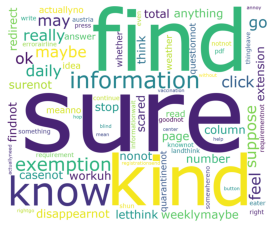

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

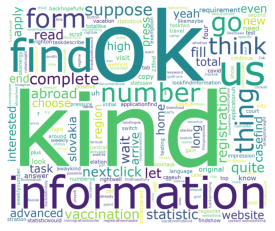

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,Spend one to spend one or two minutes familiar...,spend one spend one two minute familiarize web...,0.000000,0.000,0.0,1.000,0.0000,Neutral,None
1,"OK. OK, I'm scrolling around the website and l...",ok ok scroll around website look,0.500000,0.524,0.0,0.476,0.5267,Positive,None
2,To what I can find.,find,0.000000,1.000,0.0,0.000,0.4588,Positive,None
3,There is information about vacation testing ca...,information vacation testing call plus useful ...,0.000000,0.326,0.0,0.674,0.4404,Positive,None
4,"Uh, yeah, I can switch the language and we'll ...",uh yeah switch language stats,0.000000,0.355,0.0,0.645,0.2960,Positive,None
...,...,...,...,...,...,...,...,...,...
248,3.,3,0.000000,0.000,0.0,1.000,0.0000,Neutral,None
249,If you are in a situation that you would like.,situation would like,0.000000,0.556,0.0,0.444,0.3612,Positive,[Satisfaction]
250,"Yeah, we actually planning to wislocki I would...",yeah actually plan wislocki would feel confide...,0.466667,0.545,0.0,0.455,0.8126,Positive,None
251,Not really too.,not really,0.200000,0.000,0.0,1.000,0.0000,Neutral,None


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

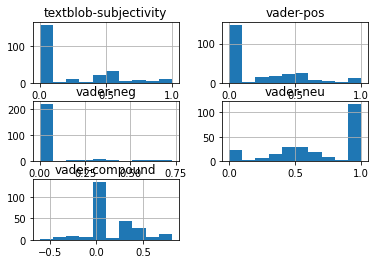

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

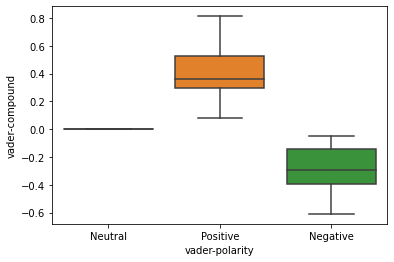

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

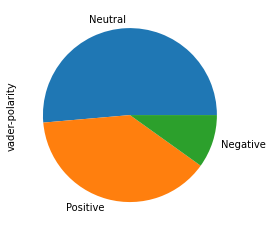

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
92,So you have no idea what kind of exemptions yo...,no idea kind exemption mean,0.793750,0.000,0.624,0.376,-0.6093,Negative,None
45,I don't know if it's like daily or weekly.,not know like daily weekly,0.000000,0.000,0.605,0.395,-0.5559,Negative,[Satisfaction]
219,I sent this so annoying actually it just.,send annoy actually,0.100000,0.000,0.592,0.408,-0.4404,Negative,None
135,It's not some kind of information.,not kind information,0.900000,0.000,0.581,0.419,-0.4168,Negative,None
172,Wait is this the error?,wait error,0.000000,0.000,0.730,0.270,-0.4019,Negative,None
94,"Didn't really found it, so I can't answer this...",not really find not answer question,0.200000,0.000,0.350,0.650,-0.4013,Negative,None
66,Not sure information is redirects me to the ot...,not sure information redirect page kind scared...,0.894444,0.184,0.383,0.433,-0.3944,Negative,None
223,I need to click some buttons which I don't kno...,need click button not know mean right,0.611607,0.000,0.292,0.708,-0.3570,Negative,None
131,Didn't feel that good about it.,not feel good,0.600000,0.000,0.546,0.454,-0.3412,Negative,None
93,There is no exemption from quarantine.,no exemption quarantine,0.000000,0.000,0.524,0.476,-0.2960,Negative,None


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
250,"Yeah, we actually planning to wislocki I would...",yeah actually plan wislocki would feel confide...,0.466667,0.545,0.000,0.455,0.8126,Positive,None
16,Maybe some kind of tabs where I can on the top...,maybe kind tab top choose interested test vacc...,0.633333,0.568,0.000,0.432,0.7845,Positive,None
52,Task #5 Find the information about exemptions ...,task 5 find information exemption cold pool ho...,0.750000,0.461,0.000,0.539,0.7717,Positive,None
19,Find the information about which region in Slo...,find information region slovakia high number t...,0.581429,0.447,0.000,0.553,0.7402,Positive,None
187,There are definitely some kind of rules.,definitely kind rule,0.900000,0.859,0.000,0.141,0.7269,Positive,None
127,Some kind of third party thing.,kind third party thing,0.450000,0.753,0.000,0.247,0.7269,Positive,None
190,Straight up on the registration form like ther...,straight registration form like information like,0.400000,0.697,0.000,0.303,0.7096,Positive,"[Satisfaction, Satisfaction]"
231,Now I would expect a form like there is some k...,would expect form like kind instruction form f...,0.900000,0.457,0.000,0.543,0.7096,Positive,"[Expectation, Satisfaction]"
199,So that's so annoying that I click on the home...,annoying click home button think relax origina...,0.850000,0.470,0.148,0.383,0.7096,Positive,None
83,Hopefully I found it in.,hopefully find,0.000000,1.000,0.000,0.000,0.6908,Positive,None
